<a href="https://colab.research.google.com/github/peterbabulik/OTOCs/blob/main/Scrambling_Kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 72.5 MB/s eta 0:00:00


Starting the Layered Scrambling Kernel experiment (Corrected)...
Testing n_layers = 1...
  -> Accuracy = 0.6000
Testing n_layers = 2...
  -> Accuracy = 0.4000
Testing n_layers = 3...
  -> Accuracy = 0.6000
Testing n_layers = 4...
  -> Accuracy = 0.5333
Testing n_layers = 5...
  -> Accuracy = 0.4667
Testing n_layers = 6...
  -> Accuracy = 0.4667
Testing n_layers = 7...
  -> Accuracy = 0.4000
Testing n_layers = 8...
  -> Accuracy = 0.3333
Testing n_layers = 9...
  -> Accuracy = 0.4333
Testing n_layers = 10...
  -> Accuracy = 0.5000
Experiment complete!


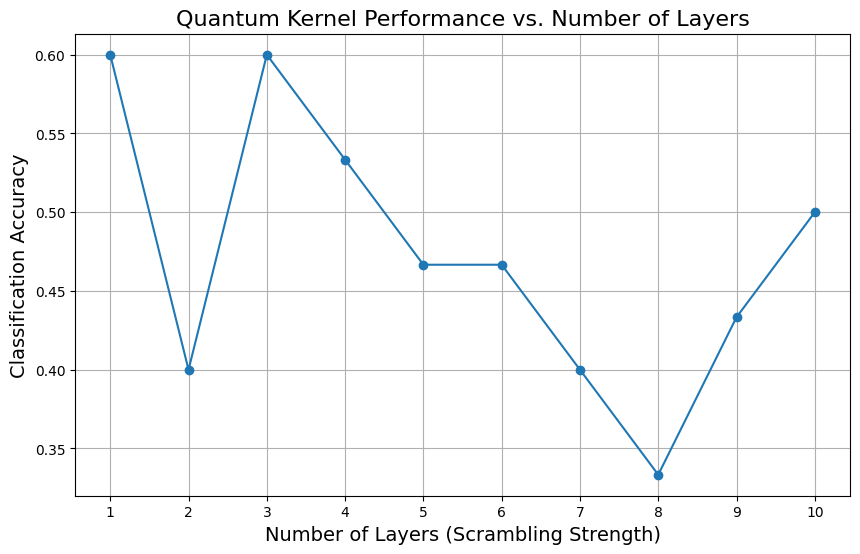

In [6]:
# Step 0: Install necessary libraries
# !pip install cirq sklearn --quiet

import cirq
import numpy as np
import sympy
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- 1. Prepare the Classical Dataset ---
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# --- 2. Design the Layered Feature Map (This part is correct) ---

def data_encoding_layer(qubits, symbols):
    circuit = cirq.Circuit()
    for i in range(len(qubits)):
        circuit.append(cirq.rx(symbols[0] * np.pi).on(qubits[i]))
        circuit.append(cirq.rz(symbols[1] * np.pi).on(qubits[i]))
    return circuit

def entangling_layer(qubits):
    circuit = cirq.Circuit()
    for i in range(0, len(qubits) - 1, 2):
        circuit.append(cirq.CZ(qubits[i], qubits[i+1]))
    for i in range(1, len(qubits) - 1, 2):
        circuit.append(cirq.CZ(qubits[i], qubits[i+1]))
    return circuit

def create_layered_feature_map(qubits, n_layers):
    data_symbols = sympy.symbols('x_0, x_1')
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(*qubits))
    for _ in range(n_layers):
        circuit.append(data_encoding_layer(qubits, data_symbols))
        circuit.append(entangling_layer(qubits))
    return circuit, data_symbols

# --- 3. Function to Compute the Kernel Matrix (THE FINAL FIX IS HERE) ---

def calculate_kernel_matrix(circuit, data_symbols, data_points_1, data_points_2):
    """Computes the quantum kernel matrix with correct symbol handling."""
    n_points_1 = len(data_points_1)
    n_points_2 = len(data_points_2)

    # --- FIX: Use cirq.resolve_parameters for symbol-to-symbol substitution ---
    # 1. Create a symbol map to rename symbols for the inverse part
    symbol_map = {sym: sympy.Symbol(f'{sym.name}_inv') for sym in data_symbols}

    # 2. Get the inverse circuit template
    inv_circuit_template = cirq.inverse(circuit)

    # 3. Create the renamed inverse circuit using the correct function
    inv_circuit_renamed = cirq.resolve_parameters(inv_circuit_template, symbol_map)

    # 4. Get the new, renamed symbols for the inverse part
    inv_symbols = [symbol_map[sym] for sym in data_symbols]
    # ---

    full_circuit = circuit + inv_circuit_renamed

    resolvers = []
    for x_i in data_points_1:
        for x_j in data_points_2:
            res_i = {sym: val for sym, val in zip(data_symbols, x_i)}
            res_j = {sym: val for sym, val in zip(inv_symbols, x_j)}
            resolvers.append(cirq.ParamResolver({**res_i, **res_j}))

    simulator = cirq.Simulator()
    results = simulator.simulate_sweep(full_circuit, params=resolvers)

    probabilities = [np.abs(res.final_state_vector[0])**2 for res in results]
    return np.array(probabilities).reshape(n_points_1, n_points_2)

# --- 4. The Main Experiment Loop (no changes needed) ---

n_qubits = 4
qubits = cirq.LineQubit.range(n_qubits)

n_layers_list = np.arange(1, 11)
accuracies = []

print("Starting the Layered Scrambling Kernel experiment (Corrected)...")
for n_layers in n_layers_list:
    print(f"Testing n_layers = {n_layers}...")

    feature_map, data_symbols = create_layered_feature_map(qubits, n_layers=n_layers)
    kernel_train = calculate_kernel_matrix(feature_map, data_symbols, X_train, X_train)
    kernel_test = calculate_kernel_matrix(feature_map, data_symbols, X_test, X_train)

    svm = SVC(kernel='precomputed')
    svm.fit(kernel_train, y_train)

    y_pred = svm.predict(kernel_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    print(f"  -> Accuracy = {accuracy:.4f}")

print("Experiment complete!")

# --- 5. Plot the Final Results ---
plt.figure(figsize=(10, 6))
plt.plot(n_layers_list, accuracies, marker='o', linestyle='-')
plt.xlabel("Number of Layers (Scrambling Strength)", fontsize=14)
plt.ylabel("Classification Accuracy", fontsize=14)
plt.title("Quantum Kernel Performance vs. Number of Layers", fontsize=16)
plt.xticks(n_layers_list)
plt.grid(True)
plt.show()